### MLBD

In [58]:
# !pip install --upgrade pyspark
# !pip install --upgrade matplotlib==3.6.1

In [78]:
# !pip install sklearn numpy pandas datasist
# !pip install pyspark spark spark-nlp
# !pip install geopandas shapely
# !pip install matplotlib mpl_toolkits
# !pip install plotly kaleido
# !pip install -U kaleido

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from functools import reduce  # For Python 3.x
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Row
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

In [2]:
spark = SparkSession.builder.appName('airscholar').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/03 10:57:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/03 10:57:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/03 10:57:19 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/11/03 10:57:19 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/11/03 10:57:19 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/11/03 10:57:19 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
22/11/03 10:57:19 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.


In [3]:
# spark._sc.stop()

In [ ]:
# SparkFiles.

In [4]:
def readAllJSON():
    jsons = ['data.24h (1).json', 'data.24h (2).json', 'data.24h (3).json', 'data.24h (4).json', 'data.24h (5).json']
    base_data_df = []
    for i in range(0, len(jsons)):
        json = jsons[i]
    # url_file ="https://data.sensor.community/static/v2/data.24h.json"
        spark.sparkContext.addFile(json)
        t_df = spark.read.json("file://"+SparkFiles.get(f"data.24h ({i+1}).json"))
        base_data_df.append(t_df)
    return base_data_df

In [5]:
base_df = readAllJSON()

In [59]:
base_df

[DataFrame[id: bigint, location: struct<altitude:string,country:string,exact_location:bigint,id:bigint,indoor:bigint,latitude:string,longitude:string>, sampling_rate: bigint, sensor: struct<id:bigint,pin:string,sensor_type:struct<id:bigint,manufacturer:string,name:string>>, sensordatavalues: array<struct<id:bigint,value:string,value_type:string>>, timestamp: string],
 DataFrame[id: bigint, location: struct<altitude:string,country:string,exact_location:bigint,id:bigint,indoor:bigint,latitude:string,longitude:string>, sampling_rate: bigint, sensor: struct<id:bigint,pin:string,sensor_type:struct<id:bigint,manufacturer:string,name:string>>, sensordatavalues: array<struct<id:bigint,value:string,value_type:string>>, timestamp: string],
 DataFrame[id: bigint, location: struct<altitude:string,country:string,exact_location:bigint,id:bigint,indoor:bigint,latitude:string,longitude:string>, sampling_rate: bigint, sensor: struct<id:bigint,pin:string,sensor_type:struct<id:bigint,manufacturer:string,

In [6]:
base_data_df = reduce(DataFrame.unionAll, base_df)
print(base_data_df.count())
base_data_df = base_data_df.distinct()
print(base_data_df.count())
base_data_df.show()

126111


125876


+-----------+--------------------+-------------+--------------------+--------------------+-------------------+
|         id|            location|sampling_rate|              sensor|    sensordatavalues|          timestamp|
+-----------+--------------------+-------------+--------------------+--------------------+-------------------+
|12743844922|{95.0, DE, 0, 266...|         null|{563, 7, {9, vari...|[{28456927724, 99...|2022-10-29 19:34:04|
|12743854488|{38.2, DE, 0, 106...|         null|{2125, 1, {14, No...|[{28456949944, 19...|2022-10-29 19:35:12|
|12743836103|{30.1, DE, 0, 165...|         null|{3293, 1, {14, No...|[{28456907514, 21...|2022-10-29 19:33:34|
|12743849854|{115.5, DE, 0, 19...|         null|{3777, 1, {14, No...|[{28456939274, 24...|2022-10-29 19:34:40|
|12743845088|{77.3, DE, 0, 197...|         null|{3917, 11, {17, B...|[{28456928200, 10...|2022-10-29 19:34:05|
|12743846667|{415.7, DE, 0, 21...|         null|{4232, 1, {14, No...|[{28456931784, 2....|2022-10-29 19:34:13|
|

In [7]:
base_data_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- location: struct (nullable = true)
 |    |-- altitude: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- exact_location: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- indoor: long (nullable = true)
 |    |-- latitude: string (nullable = true)
 |    |-- longitude: string (nullable = true)
 |-- sampling_rate: long (nullable = true)
 |-- sensor: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- pin: string (nullable = true)
 |    |-- sensor_type: struct (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- manufacturer: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- sensordatavalues: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- value: string (nullable = true)
 |    |    |-- value_type: string (nullable = true)
 |-- timestamp: string (nullable

In [8]:
base_data_df = base_data_df.withColumn('timestamp', base_data_df.timestamp.cast(TimestampType()))
base_data_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- location: struct (nullable = true)
 |    |-- altitude: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- exact_location: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- indoor: long (nullable = true)
 |    |-- latitude: string (nullable = true)
 |    |-- longitude: string (nullable = true)
 |-- sampling_rate: long (nullable = true)
 |-- sensor: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- pin: string (nullable = true)
 |    |-- sensor_type: struct (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- manufacturer: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- sensordatavalues: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- value: string (nullable = true)
 |    |    |-- value_type: string (nullable = true)
 |-- timestamp: timestamp (nulla

In [10]:
sensor_df = base_data_df\
    .withColumn('manufacturer', base_data_df.sensor.sensor_type.getField('manufacturer'))\
    .withColumn('sdvID', base_data_df.sensordatavalues.getField('id').cast(StringType()))\
    .withColumn('sdvValue', base_data_df.sensordatavalues.getField('value'))\
    .withColumn('sdvValue_type', base_data_df.sensordatavalues.getField('value_type'))

sensor_df = sensor_df.drop('sampling_rate', 'sensor', 'sensordatavalues')
sensor_df = sensor_df.filter(array_contains(sensor_df['sdvValue_type'], 'P1') & array_contains(sensor_df['sdvValue_type'], 'P2'))
sensor_df = sensor_df.withColumn('P1_Pos', array_position(sensor_df.sdvValue_type, "P1")-1).withColumn('P2_Pos', array_position(sensor_df.sdvValue_type, "P2")-1)
sensor_df = sensor_df.withColumn('P1', sensor_df['sdvValue'][sensor_df.P1_Pos.cast(IntegerType())])\
    .withColumn('P2', sensor_df['sdvValue'][sensor_df.P2_Pos.cast(IntegerType())])
sensor_df.withColumn('P1', sensor_df.P1.cast(FloatType())).withColumn('P2', sensor_df.P2.cast(FloatType()))
sensor_df = sensor_df.withColumn('P1_AQI', \
                     when((sensor_df.P1 >= 0) & (sensor_df.P1 <= 16), lit(1))\
                     .when((sensor_df.P1 >= 17) & (sensor_df.P1 <= 33), lit(2))\
                     .when((sensor_df.P1 >= 34) & (sensor_df.P1 <= 50), lit(3))\
                     .when((sensor_df.P1 >= 51) & (sensor_df.P1 <= 58), lit(4))\
                     .when((sensor_df.P1 >= 59) & (sensor_df.P1 <= 66), lit(5))\
                     .when((sensor_df.P1 >= 67) & (sensor_df.P1 <= 75), lit(6))\
                     .when((sensor_df.P1 >= 76) & (sensor_df.P1 <= 83), lit(7))\
                     .when((sensor_df.P1 >= 84) & (sensor_df.P1 <= 91), lit(8))\
                     .when((sensor_df.P1 >= 92) & (sensor_df.P1 <= 100), lit(9))\
                     .when((sensor_df.P1 > 100), lit(10))\
                    )
sensor_df = sensor_df.withColumn('P2_AQI', \
                         when((sensor_df.P2 >= 0) & (sensor_df.P2 <= 11), lit(1))\
                         .when((sensor_df.P2 >= 12) & (sensor_df.P2 <= 23), lit(2))\
                         .when((sensor_df.P2 >= 24) & (sensor_df.P2 <= 35), lit(3))\
                         .when((sensor_df.P2 >= 36) & (sensor_df.P2 <= 41), lit(4))\
                         .when((sensor_df.P2 >= 42) & (sensor_df.P2 <= 47), lit(5))\
                         .when((sensor_df.P2 >= 48) & (sensor_df.P2 <= 53), lit(6))\
                         .when((sensor_df.P2 >= 54) & (sensor_df.P2 <= 58), lit(7))\
                         .when((sensor_df.P2 >= 59) & (sensor_df.P2 <= 64), lit(8))\
                         .when((sensor_df.P2 >= 65) & (sensor_df.P2 <= 69), lit(9))\
                         .when((sensor_df.P2 > 70), lit(10))\
                        )
sensor_df = sensor_df.withColumn('AQI', when((sensor_df.P1_AQI < sensor_df.P2_AQI), lit(sensor_df.P2_AQI)).otherwise(lit(sensor_df.P1_AQI)))
sensor_df = sensor_df.withColumn('AQI_Range', \
                         when((sensor_df.AQI >= 1) & (sensor_df.AQI <= 3), lit('Low'))\
                         .when((sensor_df.AQI >= 4) & (sensor_df.AQI <= 6), lit('Medium'))\
                         .when((sensor_df.AQI >= 7) & (sensor_df.AQI <= 9), lit('High'))\
                         .when((sensor_df.AQI == 10), lit('Very High'))\
                        )
sensor_df = sensor_df.withColumn('country', base_data_df.location.getField('country'))\
    .withColumn('latitude', sensor_df.location.getField('latitude').cast(FloatType()))\
    .withColumn('longitude', sensor_df.location.getField('longitude').cast(FloatType())).drop('location')
sensor_df = sensor_df.drop('sdvID','sdvValue_type', 'sdvValue', 'P1_Pos', 'P2_Pos')


In [11]:
# print(sensor_df.printSchema())
sensor_df.show()

+-----------+-------------------+------------+-------+------+------+------+---+---------+-------+--------+---------+
|         id|          timestamp|manufacturer|     P1|    P2|P1_AQI|P2_AQI|AQI|AQI_Range|country|latitude|longitude|
+-----------+-------------------+------------+-------+------+------+------+---+---------+-------+--------+---------+
|12743854488|2022-10-29 19:35:12|Nova Fitness|1999.90|999.90|    10|    10| 10|Very High|     DE|  52.512|   13.424|
|12743836103|2022-10-29 19:33:34|Nova Fitness|  21.13|  9.74|     2|     1|  2|      Low|     DE|   51.47|     6.77|
|12743849854|2022-10-29 19:34:40|Nova Fitness|  24.67|  8.42|     2|     1|  2|      Low|     DE|  50.076|     8.66|
|12743846667|2022-10-29 19:34:13|Nova Fitness|   2.92|  1.79|     1|     1|  1|      Low|     DE|  48.472|   11.934|
|12743834697|2022-10-29 19:33:30|Nova Fitness|  25.56|  9.27|     2|     1|  2|      Low|     DE|  53.586|    9.928|
|12743845870|2022-10-29 19:34:08|Nova Fitness|  14.53|  7.72|   

In [12]:
def extractSensor(base_df):
    sensor_df = base_data_df\
    .withColumn('manufacturer', base_data_df.sensor.sensor_type.getField('manufacturer'))\
    .withColumn('sdvID', base_data_df.sensordatavalues.getField('id').cast(StringType()))\
    .withColumn('sdvValue', base_data_df.sensordatavalues.getField('value'))\
    .withColumn('sdvValue_type', base_data_df.sensordatavalues.getField('value_type'))
    sensor_df = sensor_df.drop('sampling_rate', 'sensor', 'sensordatavalues')
    
    sensor_df = sensor_df.filter(array_contains(sensor_df['sdvValue_type'], 'P1') & array_contains(sensor_df['sdvValue_type'], 'P2'))

    sensor_df = sensor_df.withColumn('P1_Pos', array_position(sensor_df.sdvValue_type, "P1")-1).withColumn('P2_Pos', array_position(sensor_df.sdvValue_type, "P2")-1)
    sensor_df = sensor_df.withColumn('P1', sensor_df['sdvValue'][sensor_df.P1_Pos.cast(IntegerType())])\
    .withColumn('P2', sensor_df['sdvValue'][sensor_df.P2_Pos.cast(IntegerType())])

    sensor_df.withColumn('P1', sensor_df.P1.cast(FloatType())).withColumn('P2', sensor_df.P2.cast(FloatType()))
    
    sensor_df = sensor_df.withColumn('P1_AQI', \
                     when((sensor_df.P1 >= 0) & (sensor_df.P1 <= 16), lit(1))\
                     .when((sensor_df.P1 >= 17) & (sensor_df.P1 <= 33), lit(2))\
                     .when((sensor_df.P1 >= 34) & (sensor_df.P1 <= 50), lit(3))\
                     .when((sensor_df.P1 >= 51) & (sensor_df.P1 <= 58), lit(4))\
                     .when((sensor_df.P1 >= 59) & (sensor_df.P1 <= 66), lit(5))\
                     .when((sensor_df.P1 >= 67) & (sensor_df.P1 <= 75), lit(6))\
                     .when((sensor_df.P1 >= 76) & (sensor_df.P1 <= 83), lit(7))\
                     .when((sensor_df.P1 >= 84) & (sensor_df.P1 <= 91), lit(8))\
                     .when((sensor_df.P1 >= 92) & (sensor_df.P1 <= 100), lit(9))\
                     .when((sensor_df.P1 > 100), lit(10))\
                    )
    sensor_df = sensor_df.withColumn('P2_AQI', \
                         when((sensor_df.P2 >= 0) & (sensor_df.P2 <= 11), lit(1))\
                         .when((sensor_df.P2 >= 12) & (sensor_df.P2 <= 23), lit(2))\
                         .when((sensor_df.P2 >= 24) & (sensor_df.P2 <= 35), lit(3))\
                         .when((sensor_df.P2 >= 36) & (sensor_df.P2 <= 41), lit(4))\
                         .when((sensor_df.P2 >= 42) & (sensor_df.P2 <= 47), lit(5))\
                         .when((sensor_df.P2 >= 48) & (sensor_df.P2 <= 53), lit(6))\
                         .when((sensor_df.P2 >= 54) & (sensor_df.P2 <= 58), lit(7))\
                         .when((sensor_df.P2 >= 59) & (sensor_df.P2 <= 64), lit(8))\
                         .when((sensor_df.P2 >= 65) & (sensor_df.P2 <= 69), lit(9))\
                         .when((sensor_df.P2 > 70), lit(10))\
                        )
    sensor_df = sensor_df.withColumn('AQI', when((sensor_df.P1_AQI < sensor_df.P2_AQI), lit(sensor_df.P2_AQI)).otherwise(lit(sensor_df.P1_AQI)))
    sensor_df = sensor_df.withColumn('AQI_Range', \
                         when((sensor_df.AQI >= 1) & (sensor_df.AQI <= 3), lit('Low'))\
                         .when((sensor_df.AQI >= 4) & (sensor_df.AQI <= 6), lit('Medium'))\
                         .when((sensor_df.AQI >= 7) & (sensor_df.AQI <= 9), lit('High'))\
                         .when((sensor_df.AQI == 10), lit('Very High'))\
                        )
    
    sensor_df = sensor_df.withColumn('country', base_data_df.location.getField('country'))\
    .withColumn('latitude', sensor_df.location.getField('latitude').cast(FloatType()))\
    .withColumn('longitude', sensor_df.location.getField('longitude').cast(FloatType())).drop('location')
    
    sensor_df = sensor_df.drop('sdvID','sdvValue_type', 'sdvValue', 'P1_Pos', 'P2_Pos')
    return sensor_df

In [27]:
sensor_df = extractSensor(base_data_df)

# sensor_df.show()

In [28]:
sensor_df.show()
print(sensor_df.count())

+-----------+-------------------+------------+-------+------+------+------+---+---------+-------+--------+---------+
|         id|          timestamp|manufacturer|     P1|    P2|P1_AQI|P2_AQI|AQI|AQI_Range|country|latitude|longitude|
+-----------+-------------------+------------+-------+------+------+------+---+---------+-------+--------+---------+
|12743854488|2022-10-29 19:35:12|Nova Fitness|1999.90|999.90|    10|    10| 10|Very High|     DE|  52.512|   13.424|
|12743836103|2022-10-29 19:33:34|Nova Fitness|  21.13|  9.74|     2|     1|  2|      Low|     DE|   51.47|     6.77|
|12743849854|2022-10-29 19:34:40|Nova Fitness|  24.67|  8.42|     2|     1|  2|      Low|     DE|  50.076|     8.66|
|12743846667|2022-10-29 19:34:13|Nova Fitness|   2.92|  1.79|     1|     1|  1|      Low|     DE|  48.472|   11.934|
|12743834697|2022-10-29 19:33:30|Nova Fitness|  25.56|  9.27|     2|     1|  2|      Low|     DE|  53.586|    9.928|
|12743845870|2022-10-29 19:34:08|Nova Fitness|  14.53|  7.72|   

65552


In [50]:
sensor_df[['country']].distinct().count()

78

## CLUSTERING USING K-MEANS

In [29]:
print(sensor_df.count())

65552


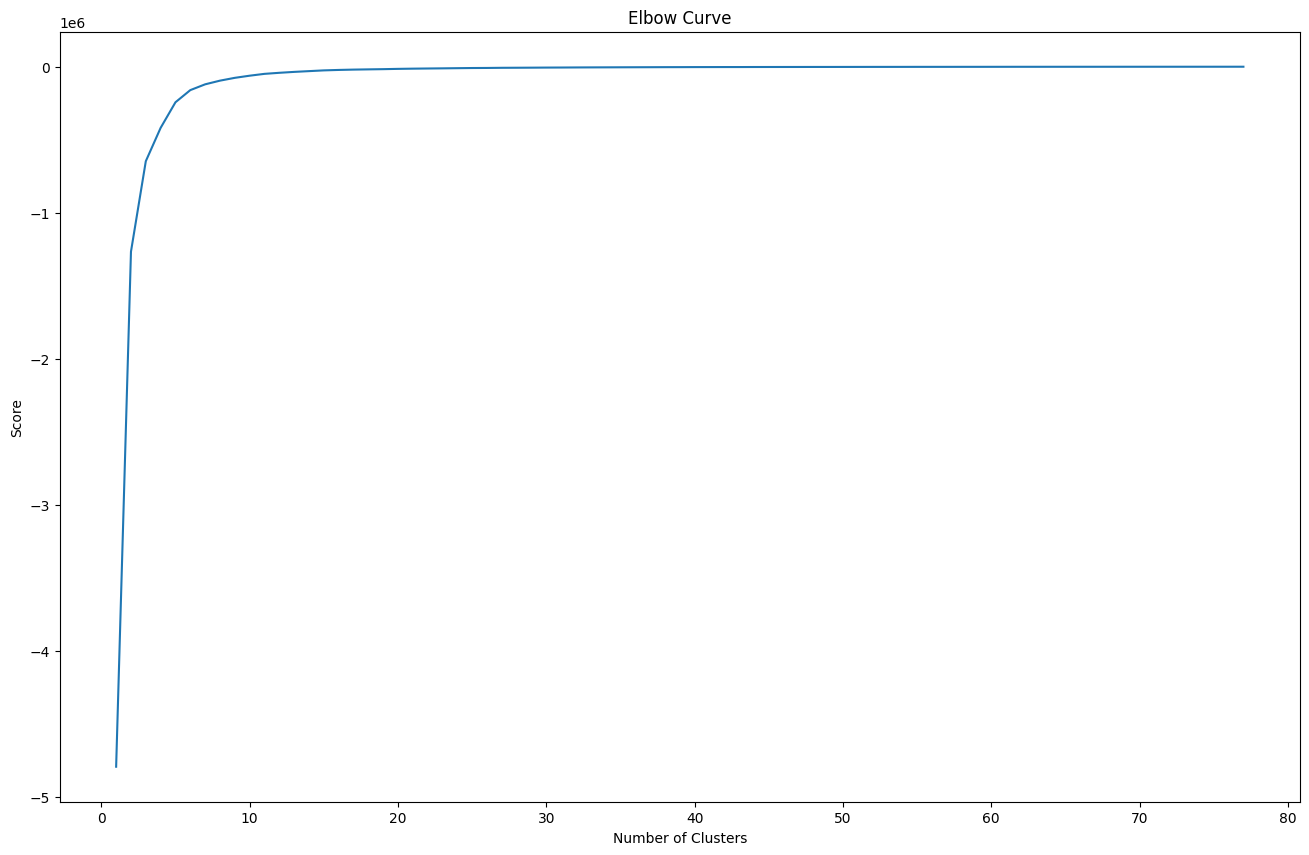

In [51]:
K_clusters = range(1,78)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = sensor_df[['latitude']].collect()
X_axis = sensor_df[['longitude']].collect()
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### From the elbow curve, we see that the graph levels off slowly after 3 clusters. This implies that addition of more clusters will not help us that much.

In [52]:
X = sensor_df.select('id', 'latitude', 'longitude')
X = X.toPandas()
X.count()

id           66318
latitude     66318
longitude    66318
dtype: int64

In [63]:
kmeans = KMeans(n_clusters = 78, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

,id,latitude,longitude,cluster_label
0,12743854488,52.512001,13.424,13
1,12743836103,51.470001,6.770,0
2,12743849854,50.076000,8.660,61
3,12743846667,48.472000,11.934,8
4,12743834697,53.585999,9.928,52
5,12743845870,52.444000,13.556,13
6,12743846639,49.183998,9.722,17
7,12740035438,47.875999,8.346,72
8,12740035438,47.875999,8.346,72
9,12743840580,49.048000,8.468,61


In [64]:
X['cluster_label'].value_counts()

32    6425
0     5129
17    4742
8     3481
61    3435
      ... 
77      15
39      10
59      10
73       5
71       5
Name: cluster_label, Length: 78, dtype: int64

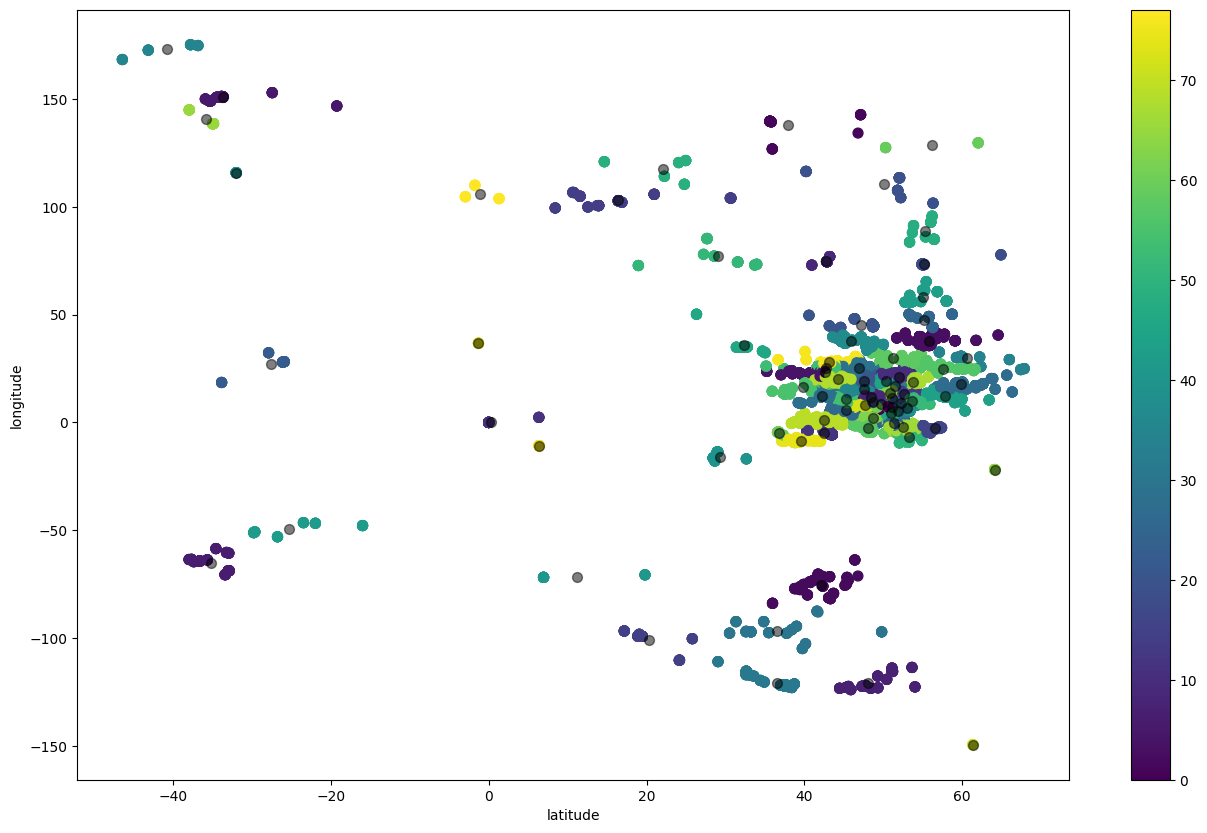

In [65]:
# plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.figsize'] = [16, 10]
X.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.5)

In [67]:
X_spark = spark.createDataFrame(X)
# X_spark.show()
sensor_df = sensor_df.join(X_spark, ['id', 'latitude', 'longitude'], how='leftouter')

In [72]:
# print(sensor_df.count(), X_spark.count())
sensor_df.show()

+-----------+--------+---------+-------------------+------------+-------+------+------+------+---+---------+-------+-------------+-------------+-------------+-------------+
|         id|latitude|longitude|          timestamp|manufacturer|     P1|    P2|P1_AQI|P2_AQI|AQI|AQI_Range|country|cluster_label|cluster_label|cluster_label|cluster_label|
+-----------+--------+---------+-------------------+------------+-------+------+------+------+---+---------+-------+-------------+-------------+-------------+-------------+
|12743854488|  52.512|   13.424|2022-10-29 19:35:12|Nova Fitness|1999.90|999.90|    10|    10| 10|Very High|     DE|            0|           35|           13|           13|
|12743836103|   51.47|     6.77|2022-10-29 19:33:34|Nova Fitness|  21.13|  9.74|     2|     1|  2|      Low|     DE|            0|            0|            0|            0|
|12743849854|  50.076|     8.66|2022-10-29 19:34:40|Nova Fitness|  24.67|  8.42|     2|     1|  2|      Low|     DE|            0|     

In [73]:
hist = sensor_df.groupby('country', 'cluster_label').count().toPandas()

AnalysisException: Reference 'cluster_label' is ambiguous, could be: cluster_label, cluster_label, cluster_label, cluster_label.

+------------+-----+
|manufacturer|count|
+------------+-----+
|       Bosch|   10|
|   Plantower| 2251|
|   Honeywell|   35|
|Sensirion AG|  789|
|     Shinyei|   10|
| TERA Sensor|    5|
|Nova Fitness|63218|
+------------+-----+



<AxesSubplot: xlabel='manufacturer'>

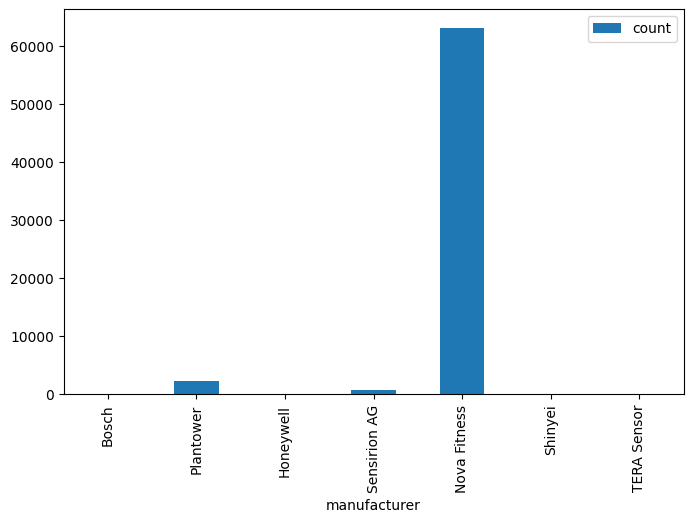

In [37]:
# get manufacturer graph
plt.rcParams['figure.figsize'] = [8,5]
manufacturers_df = sensor_df.groupby(sensor_df.manufacturer).count()
manufacturers_df.show()
manufacturers_df = manufacturers_df.toPandas()
manufacturers_df.plot.bar(x='manufacturer', y='count')

In [38]:
country_aqi_df = sensor_df.select('country', 'timestamp', 'AQI', 'AQI_Range').withColumn('timestamp', sensor_df.timestamp.cast(DateType()))
# country_aqi_df.show()
grouped_caqi_df = country_aqi_df.groupBy('country', 'timestamp').agg(mean('AQI').alias('Total_AQI'))
grouped_caqi_df = grouped_caqi_df.sort(grouped_caqi_df.Total_AQI.desc(), grouped_caqi_df.country.asc(), grouped_caqi_df.timestamp.asc())
grouped_caqi_df.show()

+-------+----------+-----------------+
|country| timestamp|        Total_AQI|
+-------+----------+-----------------+
|     SA|2022-10-29|             10.0|
|     SA|2022-10-30|             10.0|
|     SA|2022-10-31|             10.0|
|     SA|2022-11-01|             10.0|
|     ID|2022-10-29|              9.0|
|     IN|2022-11-01|8.333333333333334|
|     IN|2022-10-31|              8.0|
|     IN|2022-10-29|7.666666666666667|
|     HU|2022-10-28|              7.0|
|     PK|2022-10-31|              7.0|
|     IN|2022-10-30|              6.5|
|     PK|2022-11-01|              6.5|
|     PK|2022-10-30|             6.25|
|     RS|2022-10-31|5.982456140350878|
|     KG|2022-10-29|            5.875|
|     PK|2022-10-29|             5.75|
|     KG|2022-10-30|              5.5|
|     RS|2022-11-01|            5.375|
|     VN|2022-10-29|             5.25|
|     KG|2022-11-01|              5.0|
+-------+----------+-----------------+
only showing top 20 rows



In [36]:
# plot just a top 10 countries
# grouped_caqi_df = spark.createDataFrame(grouped_caqi_df)

In [39]:
caqi_pivot = grouped_caqi_df.pandas_api().pivot(columns='country', values='Total_AQI', index='timestamp')
# caqi_pivot = caqi_pivot
caqi_pivot

22/11/03 11:08:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


country,AD,AL,AR,AT,AU,AX,AZ,BA,BE,BG,BJ,BR,BY,CA,CD,CH,CL,CN,CO,CY,CZ,DE,DK,DO,EE,ES,FI,FR,GB,GR,HK,HR,HU,ID,IE,IL,IN,IS,IT,JP,KE,KG,KH,KR,KZ,LR,LT,LU,LV,MD,ME,MK,MT,MX,NL,NO,NP,NZ,PH,PK,PL,PT,RO,RS,RU,SA,SE,SG,SI,SK,TH,TR,TW,UA,UK,US,VN,ZA
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-11-01,1.0,3.111111,1.736842,2.033557,1.017857,1.5,2.0,4.50000,1.351433,1.699329,2.0,1.000000,1.368421,1.263158,1.0,1.517241,1.000000,3.500000,1.0,1.333333,2.848101,2.048125,1.666667,1.0,1.333333,1.818182,1.312500,1.387019,1.394595,1.705882,1.0,4.333333,2.818182,4.0,2.127660,1.000000,8.333333,1.333333,1.747619,1.000,2.0,5.000,2.0,1.0,1.5,2.000000,2.000000,1.409091,1.583333,2.0,1.0,2.916667,1.0,1.533333,1.665054,2.333333,3.0,1.2,2.0,6.50,3.901758,1.115385,2.536585,5.375000,1.430020,10.0,1.688889,3.0,1.70,2.735849,2.769231,2.333333,2.0,1.410714,1.0,1.717647,1.50,1.500000
2022-10-30,1.0,2.200000,1.342105,1.920608,1.000000,2.0,2.0,3.53125,1.596992,1.567174,2.0,1.000000,1.475000,1.277778,1.0,1.464789,1.333333,2.083333,1.0,1.000000,2.688312,1.637771,2.000000,2.0,1.166667,1.621795,1.066667,1.506993,1.586022,1.470588,1.0,2.692308,3.873747,3.5,1.684211,2.666667,6.500000,1.333333,1.579518,1.125,2.0,5.500,1.0,1.0,1.5,1.666667,1.333333,2.045455,1.224490,1.5,1.0,3.384615,1.0,1.733333,1.773069,1.500000,2.5,1.0,1.0,6.25,2.353783,1.229167,2.480263,4.610860,1.314516,10.0,1.452778,1.0,1.70,2.509615,3.961538,1.333333,4.0,1.428571,NaN,1.570588,5.00,1.166667
2022-10-29,1.0,2.300000,1.421053,1.878981,1.000000,1.5,1.0,3.68750,1.704802,1.528590,2.0,1.142857,2.809524,1.125000,1.0,1.296053,1.333333,1.800000,1.0,1.000000,2.225000,1.591100,1.333333,2.0,2.000000,1.939024,1.600000,1.547297,1.493671,1.235294,1.0,2.333333,3.675000,9.0,1.958333,1.666667,7.666667,1.333333,1.823266,1.000,2.0,5.875,1.0,1.0,3.0,1.666667,4.666667,1.714286,1.920000,2.5,1.0,2.583333,1.0,1.666667,2.087747,1.157895,3.0,1.0,1.0,5.75,1.943415,1.448276,2.928571,4.347107,1.616906,10.0,1.644330,2.0,1.75,2.339623,2.083333,1.333333,3.5,1.863014,NaN,1.640449,5.25,2.166667
2022-10-28,NaN,NaN,NaN,1.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,2.000000,2.666667,NaN,NaN,NaN,NaN,NaN,1.000000,4.000000,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,2.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.666667,NaN,NaN,NaN,NaN,NaN,1.666667,NaN,NaN,4.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-31,1.0,2.700000,1.105263,1.966887,1.000000,1.5,2.0,4.43750,1.826023,1.482490,2.0,1.000000,1.095238,1.263158,1.0,1.703226,1.000000,2.000000,1.0,1.000000,3.168675,1.896597,2.333333,1.0,1.000000,1.853659,1.133333,1.561947,1.345361,1.588235,1.0,3.937500,2.984674,3.0,1.916667,1.333333,8.000000,1.000000,1.800464,1.000,2.0,4.000,2.0,1.0,1.5,2.000000,1.000000,1.500000,1.708333,2.0,1.0,3.857143,1.0,1.500000,2.042699,2.000000,1.4,1.2,1.0,7.00,3.397260,1.160000,2.821429,5.982456,1.439771,10.0,2.200000,1.0,1.70,2.648148,3.857143,2.666667,2.0,1.450000,NaN,1.694118,1.50,1.666667


In [41]:
# caqi_pivot = caqi_pivot.mean().sort_values(ascending=False)

caqi_pivot = caqi_pivot.mean(axis=0).to_dataframe().rename({None: 'Mean'}, axis=1)

/Users/airscholar/miniconda3/lib/python3.9/site-packages/pyspark/pandas/internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
/Users/airscholar/miniconda3/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [42]:
caqi_pivot = caqi_pivot.sort_values(by= 'Mean', ascending=False).head(10)

<AxesSubplot: xlabel='Country'>

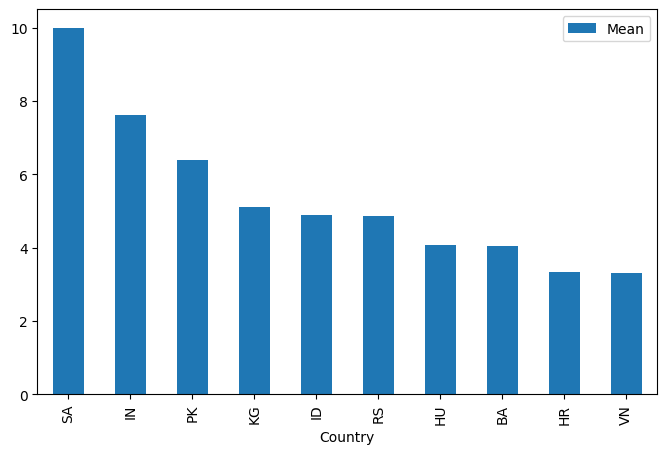

In [43]:
x = caqi_pivot['Mean'].to_dict()
x = pd.DataFrame.from_dict(x, orient='index')
x['Country'] = x.index.to_list()
x = x.rename({0: 'Mean'}, axis=1)
x = x[['Country', 'Mean']]
x.plot.bar(x='Country', y='Mean')

In [41]:
# ax = caqi_pivot.to_pandas().plot(kind="bar")
# ax.savefig('plot.jpg')

In [42]:
# country_aqi_df.select('country').distinct().show(100)

In [43]:
# sl_df = sensor_df.join(location_df, ['id', 'timestamp'], 'inner')
# print(sl_df.count())
# sl_df.show()

In [45]:
graph_df = sensor_df.toPandas()

/Users/airscholar/miniconda3/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [46]:
plt.rcParams['figure.figsize'] = [16, 10]

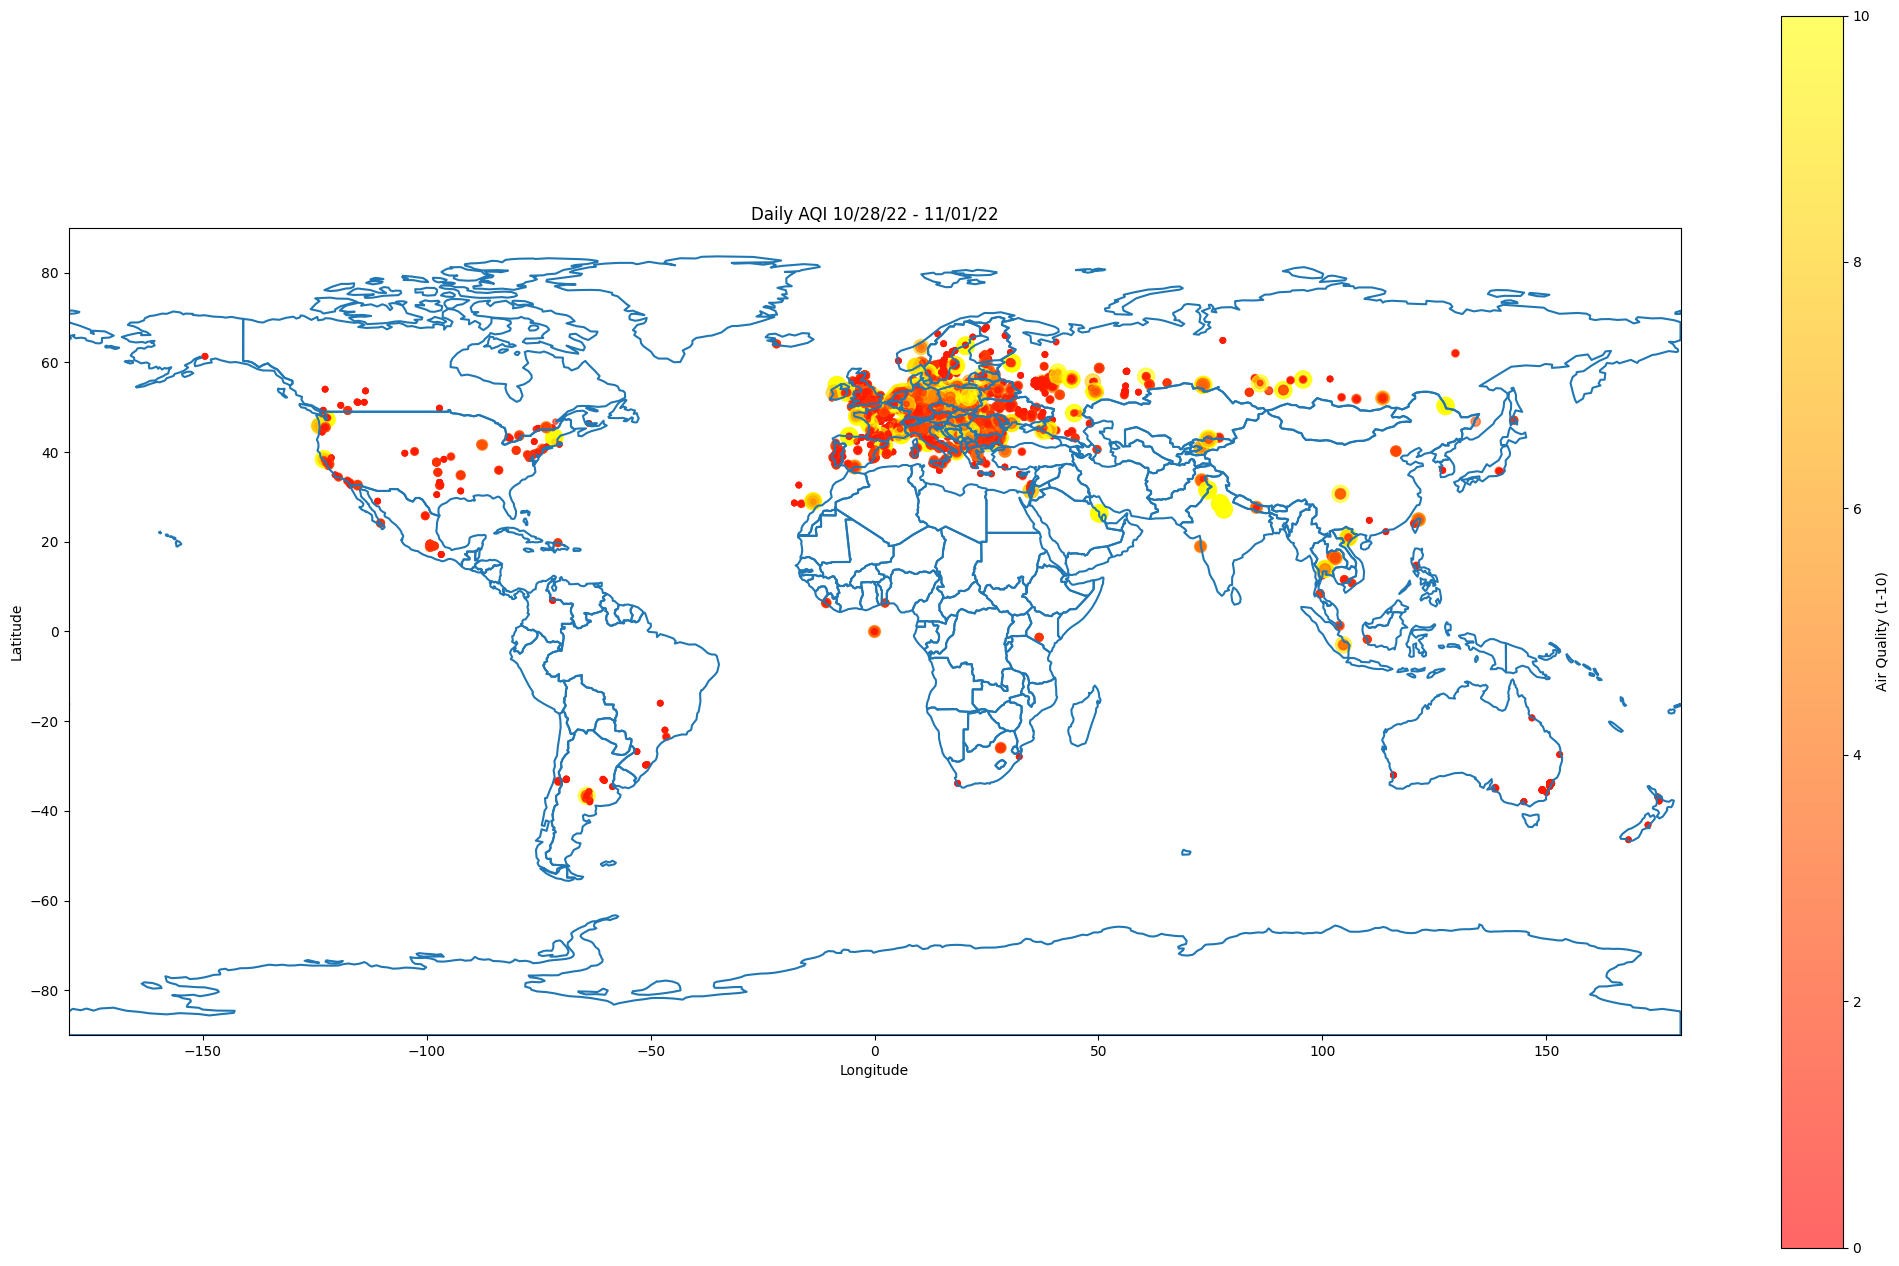

In [47]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(26, 16))
worldmap.boundary.plot(ax=ax, markersize=5)
# worldmap.plot(edgecolor="black", ax=ax, legend=True, markersize=1)
x = graph_df['longitude']
y = graph_df['latitude']
z = graph_df['AQI']

plt.scatter(x, y, s=15*z, c=z, alpha=0.6, vmin=0, cmap='autumn')
plt.colorbar(label='Air Quality (1-10)')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

first_year = graph_df["timestamp"].min().strftime("%x")
last_year = graph_df["timestamp"].max().strftime("%x")
plt.title("Daily AQI " +     
          str(first_year) + " - " + str(last_year))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [47]:
# base_sensorDV_df = base_data_df.withColumn('sensordatavalues', explode('sensordatavalues'))
# base_sensorDV_df.show(truncate=False)
# base_sensorDV_df.count()

In [48]:
# # get sensor data values
# sensorDV_df = base_sensorDV_df\
# .withColumn('sdvID', base_sensorDV_df.sensordatavalues.getField('id').cast(StringType()))\
# .withColumn('sdvValue', base_sensorDV_df.sensordatavalues.getField('value').cast(FloatType()))\
# .withColumn('sdvValue_type', base_sensorDV_df.sensordatavalues.getField('value_type'))
# sensorDV_df = sensorDV_df.drop('location', 'sampling_rate', 'sensor', 'sensordatavalues')
# sensorDV_df = sensorDV_df[sensorDV_df.sdvValue_type.isin(['P1', 'P2'])]
# print(sensorDV_df.count())
# sensorDV_df.show(10)

In [49]:
# spark.catalog.dropGlobalTempView('sensorDV')
# sensorDV_df.createGlobalTempView('sensorDV')

In [50]:
# pivotDF = sensorDV_df.groupBy("id").pivot("sdvValue_type", ['P1', 'P2']).sum("sdvValue")
# # pivotDF.where(pivotDF.id =='12726569451').show(truncate=False)
# pivotDF.count()

In [51]:
# pivotDF.show()

In [52]:
import jovian
jovian.commit(filename='MLBD.ipynb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Updating notebook "airscholar/mlbd" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/airscholar/mlbd


'https://jovian.ai/airscholar/mlbd'